In [2]:
import plotly.plotly as py
import plotly.graph_objs as graph_objs

import cufflinks as cf

import pandas as pd
import numpy as np

import sqlite3
from sqlalchemy import create_engine

In [3]:
pd.set_option('max_columns', 300)

In [4]:
engine = create_engine('sqlite:///liligo.db', echo=False)

# Some quick sneak peaks

the listings.csv.gz file contains quite a lot of info about the places

In [6]:
pd.read_sql_query('''
    select * from listings limit 1
''', engine)

,index,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,2577,https://www.airbnb.com/rooms/2577,20190205040859,2019-02-05,Loft for 4 by Canal Saint Martin,"100 m2 loft (1100 sq feet) with high ceiling, ...",The district has any service or shop you may d...,"100 m2 loft (1100 sq feet) with high ceiling, ...",none,None,None,"Metro lines : 4, 8, 3, 11, 9.",None,None,None,None,None,https://a0.muscache.com/im/pictures/09da057c-0...,None,2827,https://www.airbnb.com/users/show/2827,Karine,2008-09-09,"Casablanca, Grand Casablanca, Morocco","Arrivée à Casablanca il y a 4 ans, je suis amo...",within a few hours,80%,None,f,https://a0.muscache.com/im/pictures/17fe6c88-a...,https://a0.muscache.com/im/pictures/17fe6c88-a...,République,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Paris, Île-de-France, France",République,Entrepôt,None,Paris,Île-de-France,75010,Paris,"Paris, France",FR,France,48.869933,2.362511,t,Loft,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{TV,Internet,Wifi,Kitchen,Heating,Washer,Dryer...",None,$125.00,None,None,$0.00,$40.00,1,$0.00,3,1125,3,3,1125,1125,3.0,1125.0,3 months ago,t,0,0,0,85,2019-02-05,1,1,2019-01-02,2019-01-02,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,None,{PARIS},t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.86


In [8]:
pd.read_sql_query('''
    select count(*) as cnt from listings
''', engine)

,cnt
0,58067


In [7]:
pd.read_sql_query('''
    select count(*) as cnt from listings where has_availability = 't'
''', engine)

,cnt
0,58067


In [9]:
pd.read_sql_query('''
    select count(*) as cnt from listings where availability_90 > 0
''', engine)

,cnt
0,26699


In [10]:
pd.read_sql_query('''
    select count(*) as cnt from listings where availability_60 > 0
''', engine)

,cnt
0,24830


In [11]:
pd.read_sql_query('''
    select count(*) as cnt from listings where availability_30 > 0
''', engine)

,cnt
0,22375


# Ratings

In [13]:
pd.read_sql_query('''
    select count(*) as cnt 
    from listings 
    where 1=1
        and room_type = 'Entire home/apt'
        and availability_30 > 0
''', engine)

,cnt
0,18711


In [57]:
(
    pd
    .read_sql_query('''
        select review_scores_rating, count(*) as cnt 
        from listings 
        where 1=1
            and room_type = 'Entire home/apt'
            and availability_30 > 0
            and review_scores_rating > 0
        group by review_scores_rating
        order by review_scores_rating
    ''', engine)
    .set_index('review_scores_rating')
    .cumsum()
    [80:]
    .iplot(kind = 'bar', filename = 'paris_scores_distribution', 
           layout = graph_objs.Layout(title = 'The ratings are very high<br>45% of the places have rating of 95% and above',
                                      xaxis = dict(title = 'Rating'), yaxis = dict(title = 'Number of listings (cumulative)'))
          )
)

In [58]:
(
    pd
    .read_sql_query('''
        select 
              (cast(price_usd/10 as int) + 1) * 10 as price
            , count(*) as cnt 
        from listings 
        where 1=1
            and room_type = 'Entire home/apt'
            and availability_30 > 0
            and review_scores_rating > 0
        group by (cast(price_usd/10 as int) + 1) * 10
        order by price
    ''', engine)
    .set_index('price')
    #.cumsum()
    .loc[:200, :]
    .iplot(kind = 'bar', filename = 'paris_prices_distribution', 
           layout = graph_objs.Layout(title = 'Prices are centered around the $100-$120 region',
                                      xaxis = dict(title = 'Nightly price ($)'), yaxis = dict(title = 'Number of listings'))
          )
)

In [55]:
(
    pd
    .read_sql_query('''
        select 
              price_usd as price
            , review_scores_rating
            , count(*) as cnt
        from listings 
        where 1=1
            and room_type = 'Entire home/apt'
            and availability_30 > 0
            and review_scores_rating > 80
            and price_usd < 200
        group by
              price_usd
            , review_scores_rating
    ''', engine)
    .iplot(kind = 'bubble', x = 'price', y = 'review_scores_rating', size = 'cnt', filename = 'paris_price_rating_distribution')
)

# Correlation between ratings and prices

In [8]:
price_scores = (
    pd
    .read_sql_query('''
        select 
              price_usd as price
            , review_scores_rating as scores
        from listings 
        where 1=1
            and room_type = 'Entire home/apt'
            and availability_30 > 0
            and review_scores_rating > 80
            and price_usd < 200
    ''', engine)
)

In [9]:
price_scores.head()

,price,scores
0,115.0,93.0
1,115.0,94.0
2,90.0,100.0
3,85.0,88.0
4,79.0,89.0


In [10]:
price_scores.count()

price     12380
scores    12380
dtype: int64

### wooo, it's only 0.11!

In [11]:
price_scores['price'].corr(price_scores['scores'])

0.11104075794148578

### And taking cleaning fees into account only makes it worse

In [17]:
price_scores_with_cleaning = (
    pd
    .read_sql_query('''
        select 
              price_usd + cleaning/3 as price
            , review_scores_rating as scores
        from listings 
        where 1=1
            and room_type = 'Entire home/apt'
            and availability_30 > 0
            and review_scores_rating > 80
            and price_usd < 200
    ''', engine)
)

In [18]:
price_scores_with_cleaning.head()

,price,scores
0,127.000000,93.0
1,131.666667,94.0
2,90.000000,100.0
3,105.000000,88.0
4,87.333333,89.0


In [19]:
price_scores_with_cleaning['price'].corr(price_scores_with_cleaning['scores'])

0.08950127179722778

## correlation between price and ratings within the neighbourhoods 
well, it's higher, but still doesn't seem significant

In [20]:
price_scores_neigh = (
    pd
    .read_sql_query('''
        select 
              price_usd as price
            , review_scores_rating as scores
            , neighbourhood_cleansed as neighbourhood
        from listings 
        where 1=1
            and room_type = 'Entire home/apt'
            and availability_30 > 0
            and review_scores_rating > 80
            and price_usd < 200
    ''', engine)
)

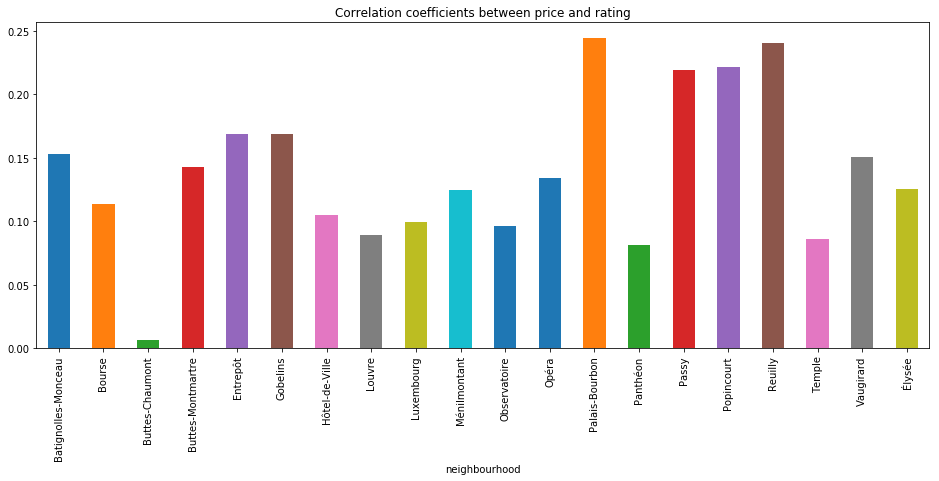

In [59]:
price_scores_neigh.groupby('neighbourhood')[['price', 'scores']].corr().iloc[0::2][['scores']].unstack().scores.price.plot(kind = 'bar', title = 'Correlation coefficients between price and rating', figsize = (16, 6));

# instant_bookable versus price
doesn't seem to matter much

In [33]:
price_instant_neigh = (
    pd
    .read_sql_query('''
        select 
              price_usd as price
            , instant_bookable
            , neighbourhood_cleansed as neighbourhood
        from listings 
        where 1=1
            and room_type = 'Entire home/apt'
            and availability_30 > 0
            and review_scores_rating > 80
            and price_usd < 200
    ''', engine)
)

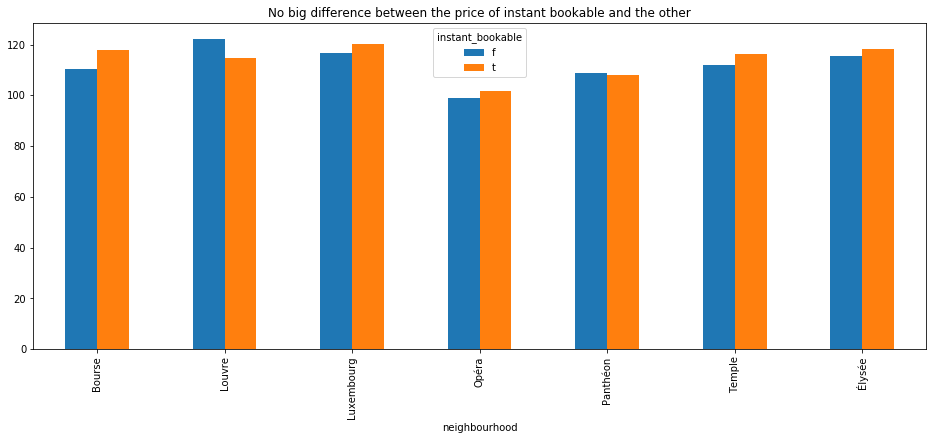

In [63]:
(
    price_instant_neigh
    .query("neighbourhood in ['Luxembourg', 'Louvre', 'Élysée', 'Hôtel', 'Temple', 'Bourse', 'Palais', 'Panthéon', 'Opéra']")
    .pivot_table(index = 'neighbourhood', columns = 'instant_bookable', values = 'price', aggfunc = ['mean', 'count'])
    ['mean']
    .plot(kind = 'bar', title = 'No big difference between the price of instant bookable and the other', figsize = (16, 6))
);

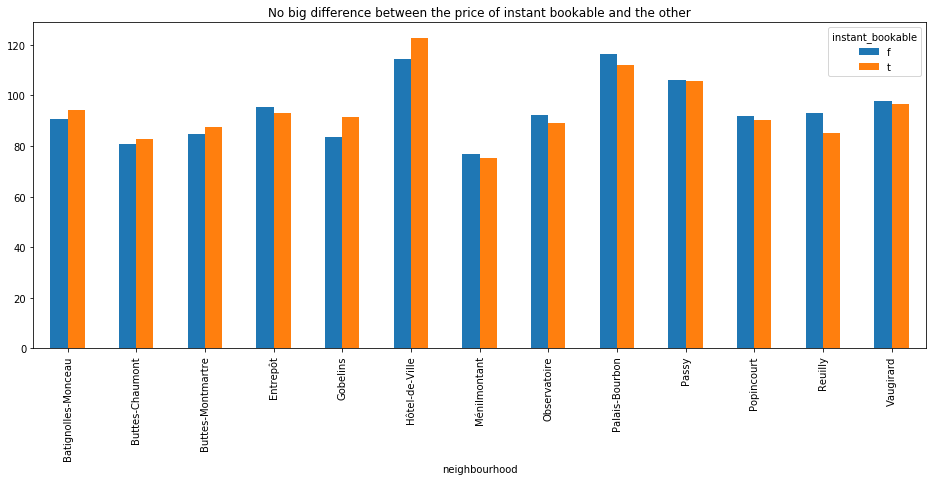

In [67]:
(
    price_instant_neigh
    .query("neighbourhood not in ['Luxembourg', 'Louvre', 'Élysée', 'Hôtel', 'Temple', 'Bourse', 'Palais', 'Panthéon', 'Opéra']")
    .pivot_table(index = 'neighbourhood', columns = 'instant_bookable', values = 'price', aggfunc = ['mean', 'count'])
    ['mean']
    .plot(kind = 'bar', title = 'No big difference between the price of instant bookable and the other', figsize = (16, 6))
);

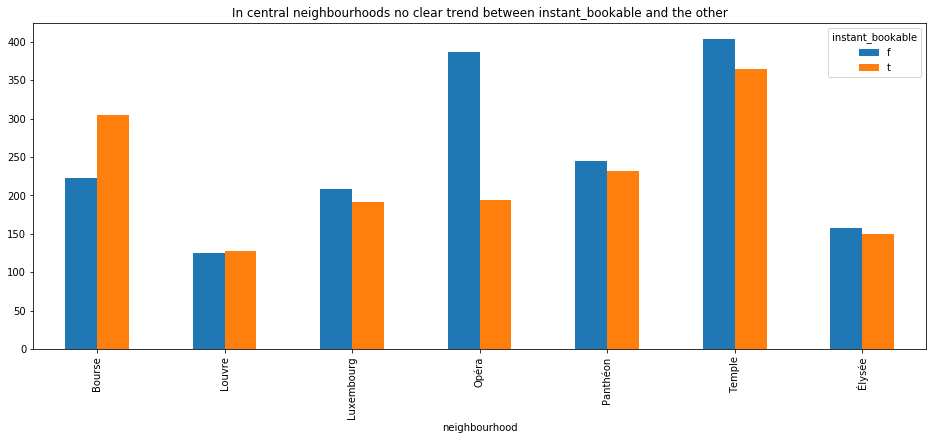

In [65]:
(
    price_instant_neigh
    .query("neighbourhood in ['Luxembourg', 'Louvre', 'Élysée', 'Hôtel', 'Temple', 'Bourse', 'Palais', 'Panthéon', 'Opéra']")
    .pivot_table(index = 'neighbourhood', columns = 'instant_bookable', values = 'price', aggfunc = ['mean', 'count'])
    ['count']
    .plot(kind = 'bar', title = 'In central neighbourhoods no clear trend between instant_bookable and the other', figsize = (16, 6))
);

# In the less central neighbourhoods Instant Bookable apartments are less common, but it doesn't have an impact on the price

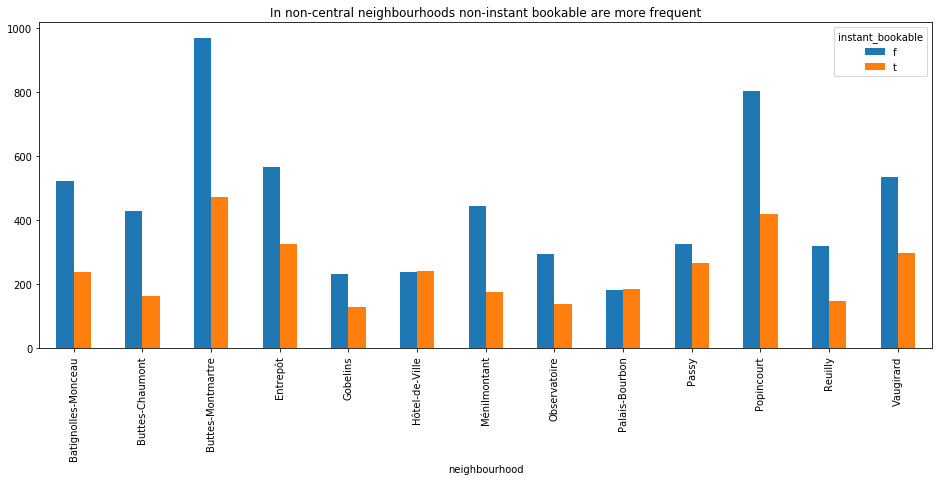

In [66]:
(
    price_instant_neigh
    .query("neighbourhood not in ['Luxembourg', 'Louvre', 'Élysée', 'Hôtel', 'Temple', 'Bourse', 'Palais', 'Panthéon', 'Opéra']")
    .pivot_table(index = 'neighbourhood', columns = 'instant_bookable', values = 'price', aggfunc = ['mean', 'count'])
    ['count']
    .plot(kind = 'bar', title = 'In non-central neighbourhoods non-instant bookable are more frequent', figsize = (16, 6))
);